In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from jupyterthemes import jtplot
from mapie.metrics import regression_coverage_score
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set_theme()

Loading electricity demand data for Monterrey location retrieved from CENACE website

In [2]:
demandaMTY = pd.read_csv('df_fullMTY.csv')
demandaMTY['Fecha'] = pd.to_datetime(demandaMTY['Fecha'])
demandaMTY.set_index('Fecha', inplace=True)
demandaMTY = demandaMTY.loc[(demandaMTY.index >= '2018-01-02') & (demandaMTY.index <= '2022-12-31')]

Loading electricity price data retrieved also from CENACE website

In [3]:
pmlMTY = pd.read_csv('PMLMTY2016_2023.csv')
pmlMTY['Fecha'] = pd.to_datetime(pmlMTY['Fecha'])
pmlMTY.set_index('Fecha', inplace=True)
pmlMTY = pmlMTY.loc[(pmlMTY.index >= '2018-01-02') & (pmlMTY.index <= '2022-12-31')]
pmlMTY.rename(columns={'Precio marginal local ($/MWh)':'PML'}, inplace=True)

As obtained from electricity price data analysis, it will be used the lags from 14, 15 and 16 days prior.

In [4]:
pmlMTYlag = pmlMTY.copy()
pmlMTYlag['PMLlag14'] = pmlMTYlag['PML'].shift(6)#14
pmlMTYlag['PMLlag15'] = pmlMTYlag['PML'].shift(13)#15
pmlMTYlag['PMLlag16'] = pmlMTYlag['PML'].shift(20)#16

Temperature variations ranging from 2018 thru 2022 fro Monterrey were obtained from NOAA (https://www.ncei.noaa.gov/cdo-web/)

In [5]:
tempMTY = pd.read_csv('WeatherMTY2017_2023.csv')
tempMTY['DATE'] = pd.to_datetime(tempMTY['DATE'])
tempMTY.set_index('DATE', inplace=True)
tempMTY = tempMTY.loc[(tempMTY.index >= '2018-01-02') & (tempMTY.index <= '2022-12-31')]
tempMTY.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','PRCP_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES', 'PRCP','TMAX','TMIN'], inplace=True)

Contatenate all data into a single dataframe

In [6]:
demandaMTY_full = demandaMTY.copy()
demandaMTY_full = pd.concat([demandaMTY_full,pmlMTYlag, tempMTY['TAVG']], axis=1)

Create function to create features tha will be used in SARIMA model

In [7]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    return df

In [8]:
def add_lags(df):
    df['lag1'] = df[' Energia (MWh) '].shift(1)
    df['lag7'] = df[' Energia (MWh) '].shift(7)
    return df

Create function to calculate statistics for the model

In [9]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mape*100,mae,mse,rmse,r2

Create function for Conformal Prediction metrics

In [10]:
def calculate_metricsforCP(y_true, lower_bound, upper_bound, alpha=0.05):

    coverage_probability_conformal = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    coverage_indicator = ((lower_bound <= y_true) & (y_true <= upper_bound)).astype(int)

    validity = abs(coverage_probability_conformal - alpha)
    sharpness = np.mean(upper_bound - lower_bound)
    interval_score = sharpness + (1 / len(y_true)) * coverage_indicator.sum()

    return validity,sharpness,interval_score

Define data for SARIMA model

In [11]:
dataforARIMA = demandaMTY_full.copy()
dataforARIMA_train = dataforARIMA.loc['2018-01-02':'2021-12-31']
dataforARIMA_test = dataforARIMA.loc['2022-01-01':'2022-12-31']

Plotting electricity demand data showing the train and test sets

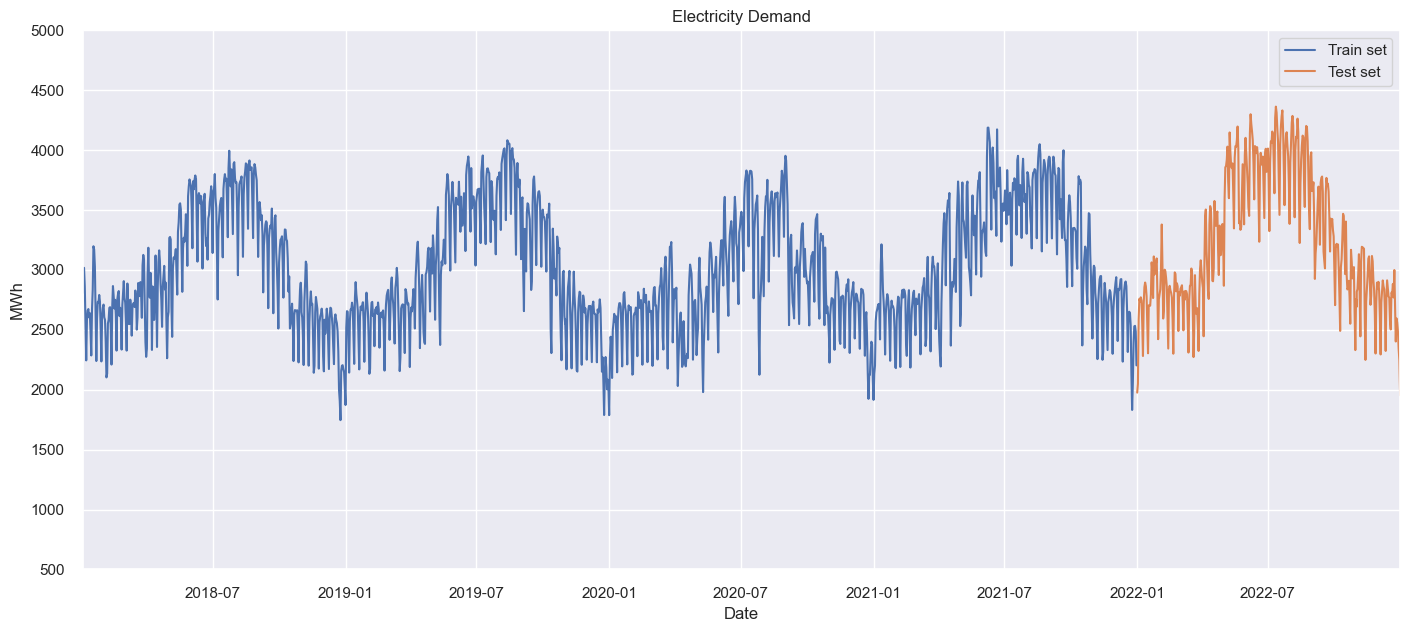

In [12]:
plt.figure(figsize=(17, 7))
plt.plot(dataforARIMA_train.index, dataforARIMA_train[' Energia (MWh) '].values, label="Train set")
plt.plot(dataforARIMA_test.index, dataforARIMA_test[' Energia (MWh) '].values, label="Test set")
plt.title("Electricity Demand")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.xlim([dataforARIMA_train.index.min(),  dataforARIMA_test.index.max()])
plt.ylim([500, 5000])
plt.legend()

Scaling data to apply SARIMA model

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dataforARIMA_exog_train = create_features(dataforARIMA_train)
dataforARIMA_exog_test = create_features(dataforARIMA_test)

dataforARIMA_exog_train = add_lags(dataforARIMA_exog_train)
dataforARIMA_exog_test = add_lags(dataforARIMA_exog_test)

FEATURES = ['dayofweek','lag1','lag7','PMLlag14','PMLlag15','PMLlag16','TAVG']
TARGET = [' Energia (MWh) ']

dataforARIMA_exog_train = dataforARIMA_exog_train[FEATURES]
dataforARIMA_exog_train = dataforARIMA_exog_train.fillna(0)
dataforARIMA_exog_test = dataforARIMA_exog_test[FEATURES]
dataforARIMA_exog_test = dataforARIMA_exog_test.fillna(0)



dataforARIMA_train_target = dataforARIMA_train[' Energia (MWh) '].values
dataforARIMA_test_target = dataforARIMA_test[' Energia (MWh) '].values


dataforARIMA_train_scaled = scaler.fit_transform(dataforARIMA_train_target.reshape(-1, 1))
dataforARIMA_test_scaled = scaler.transform(dataforARIMA_test_target.reshape(-1, 1))

Grid search for SARIMA model using pmdarima package

In [14]:
# arima_model = auto_arima(dataforARIMA_train_scaled,start_p=0,start_d=0,start_q=0, test='adf', max_p=6,max_d=3,max_q=4,
#                          start_P=0,start_D=0,start_Q=0,max_P=2,max_D=1,max_Q=2,
#                          m=7,seasonal=True,error_action='warn',trace=True,suppress_warnings=True,
#                          stepwise=True, random_state=101, n_fits=50)

****************** SARIMA model definition *******************

In [15]:
import warnings
warnings.filterwarnings('ignore')
# Best model:  ARIMA(3,1,1)(1,0,1)[7] 
arima = SARIMAX(endog=dataforARIMA_train_scaled, exog=dataforARIMA_exog_train,order=(3,1,1),seasonal_order=(1,0,1,7))
model = arima.fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1464
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -346.939
Date:                           Tue, 12 Nov 2024   AIC                            721.878
Time:                                   17:15:06   BIC                            795.914
Sample:                                        0   HQIC                           749.494
                                          - 1464                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek     -0.1286      0.003    -37.276      0.000      -0.135      -0.122
lag1           0.0006   2.69e-05     21.182

Calculate predictions for SARIMA model on test data

In [16]:
y_forecast = model.forecast(steps=len(dataforARIMA_test_scaled),exog=dataforARIMA_exog_test)

In [17]:
y_forecast_reshaped = np.ravel(y_forecast.values)
y_forecast_final = scaler.inverse_transform(y_forecast_reshaped.reshape(-1,1))
df_forecast = dataforARIMA_test.copy()
df_forecast['forecast_mean'] = y_forecast_final

Performing a Feature Importance analysis based on coefficients

In [18]:
def analyze_sarimax_coefficients(model):
    results = pd.DataFrame({
        'coef': model.params,
        'p_value': model.pvalues
    })
    exog_results = results[~results.index.str.contains('ar|ma|sigma2|const', case=False)]
    exog_results['abs_coef'] = abs(exog_results['coef'])
    exog_results = exog_results.sort_values('abs_coef', ascending=False)
    return exog_results

feature_importance = analyze_sarimax_coefficients(model)
print("\nFeature Importance based on coefficients:")
print(feature_importance)


Feature Importance based on coefficients:
               coef        p_value  abs_coef
dayofweek -0.128588  4.045157e-304  0.128588
lag7       0.000591  3.926194e-142  0.000591
lag1       0.000570   1.400751e-99  0.000570
TAVG       0.000328   6.477429e-01  0.000328
PMLlag14  -0.000019   5.479313e-01  0.000019
PMLlag16  -0.000015   6.415883e-01  0.000015
PMLlag15  -0.000004   9.093786e-01  0.000004


Performing a Cross-Correlation analysis

In [19]:
from statsmodels.tsa.stattools import ccf

def analyze_cross_correlations(target, exog_data):
    correlations = {}
    for column in exog_data.columns:
        correlation = ccf(target, exog_data[column], unbiased=True)
        correlations[column] = np.abs(correlation).max()
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', 
                                    columns=['max_correlation'])
    return corr_df.sort_values('max_correlation', ascending=False)

cross_corr = analyze_cross_correlations(dataforARIMA_train_scaled, 
                                      dataforARIMA_exog_train)
print("\nCross-correlation analysis:")
print(cross_corr)


Cross-correlation analysis:
           max_correlation
lag1              9.466811
lag7              8.858092
PMLlag14          2.564333
PMLlag15          2.540589
PMLlag16          2.515628
dayofweek         1.596447
TAVG              0.823532


Performing a variable importance based on AIC analysis

In [20]:
def compare_variable_importance(endog, exog, order, seasonal_order):
    base_aic = float('inf')
    importance = {}
    full_model = SARIMAX(endog=endog, exog=exog,
                        order=order, 
                        seasonal_order=seasonal_order).fit()
    base_aic = full_model.aic
    for col in exog.columns:
        reduced_exog = exog.drop(columns=[col])
        reduced_model = SARIMAX(endog=endog, 
                              exog=reduced_exog,
                              order=order, 
                              seasonal_order=seasonal_order).fit()
        aic_diff = reduced_model.aic - base_aic
        importance[col] = aic_diff
    importance_df = pd.DataFrame.from_dict(importance, 
                                         orient='index', 
                                         columns=['aic_difference'])
    return importance_df.sort_values('aic_difference', ascending=False)

importance_analysis = compare_variable_importance(
    dataforARIMA_train_scaled,
    dataforARIMA_exog_train,
    order=(3,1,1),
    seasonal_order=(1,0,1,7)
)
print("\nVariable importance based on AIC:")
print(importance_analysis)


Variable importance based on AIC:
           aic_difference
dayofweek      438.552727
lag1           153.528308
PMLlag16        -1.546449
PMLlag14        -1.872114
TAVG            -1.892423
PMLlag15        -1.981439
lag7           -76.685259


Performing a Residual sensitivity analysis

In [21]:
def analyze_residual_sensitivity(model, exog_data):
    residuals = model.resid
    sensitivity = {}
    for column in exog_data.columns:
        correlation = np.corrcoef(residuals, exog_data[column])[0,1]
        sensitivity[column] = abs(correlation)
    sens_df = pd.DataFrame.from_dict(sensitivity, 
                                    orient='index', 
                                    columns=['residual_correlation'])
    return sens_df.sort_values('residual_correlation', ascending=False)

residual_sensitivity = analyze_residual_sensitivity(model, 
                                                  dataforARIMA_exog_train)
print("\nResidual sensitivity analysis:")
print(residual_sensitivity)


Residual sensitivity analysis:
           residual_correlation
dayofweek              0.079986
PMLlag16               0.068930
lag1                   0.060380
lag7                   0.055524
PMLlag15               0.039856
PMLlag14               0.038576
TAVG                   0.012219


Plotting prediction values vs real values of test set

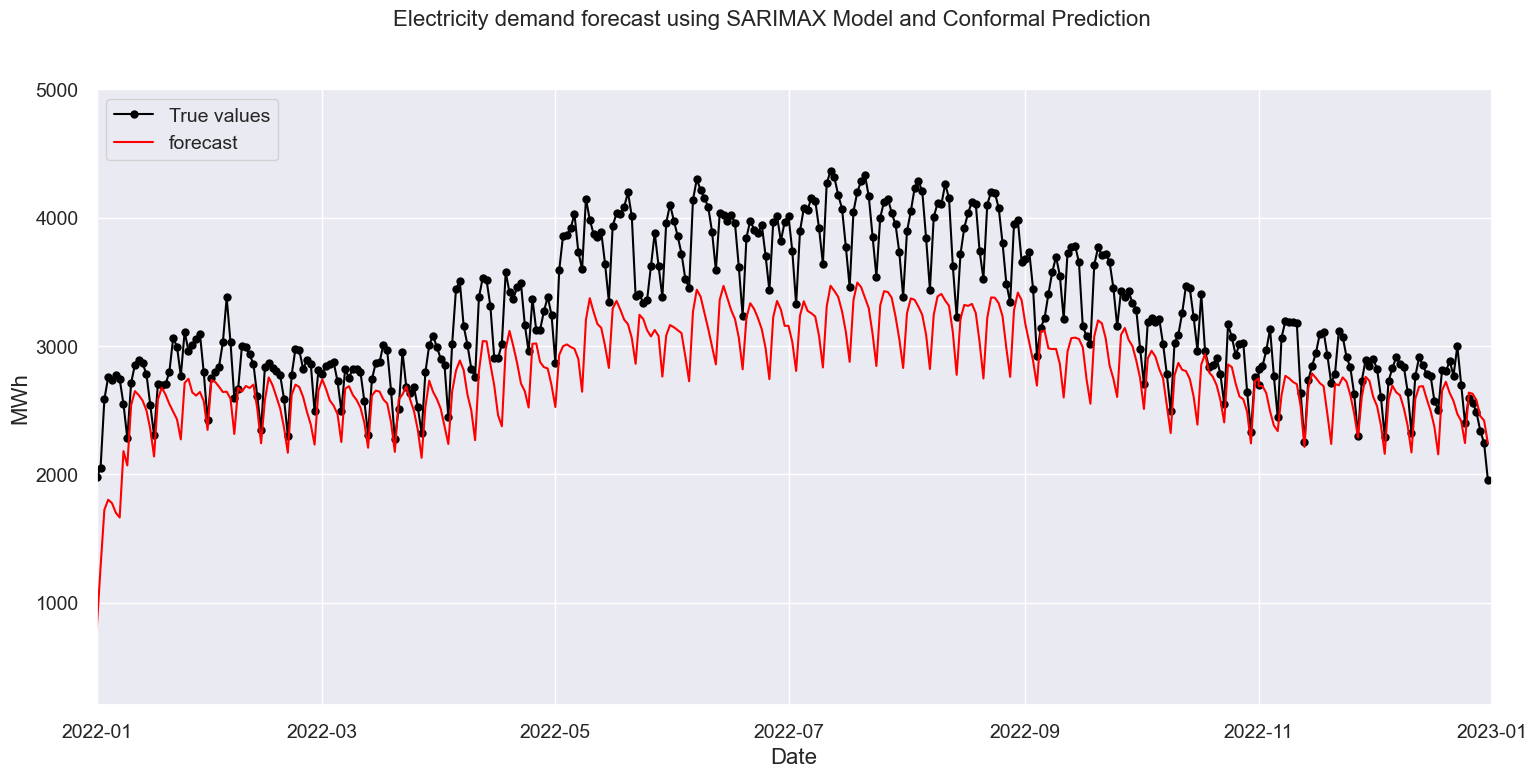

In [22]:
fig, ax1 = plt.subplots(figsize=(18,8))
fig.suptitle('Electricity demand forecast using SARIMAX Model and Conformal Prediction', fontsize=16)
ax1.plot(df_forecast.index, df_forecast[' Energia (MWh) '], marker='o', label="True values", color='black')
ax1.plot(df_forecast.index, df_forecast['forecast_mean'],label='forecast',color='red')
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([200, 5000])
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

Performing isotonic regression to calibrate the model

In [23]:
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
y_testreshape = dataforARIMA_test.copy()
y_testreshape = y_testreshape[' Energia (MWh) '].values.reshape(-1)
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(df_forecast['forecast_mean'], y_testreshape)

y_pred_calibrated_iso = ir.predict(df_forecast['forecast_mean'])

Plotting isotonic regression calibration

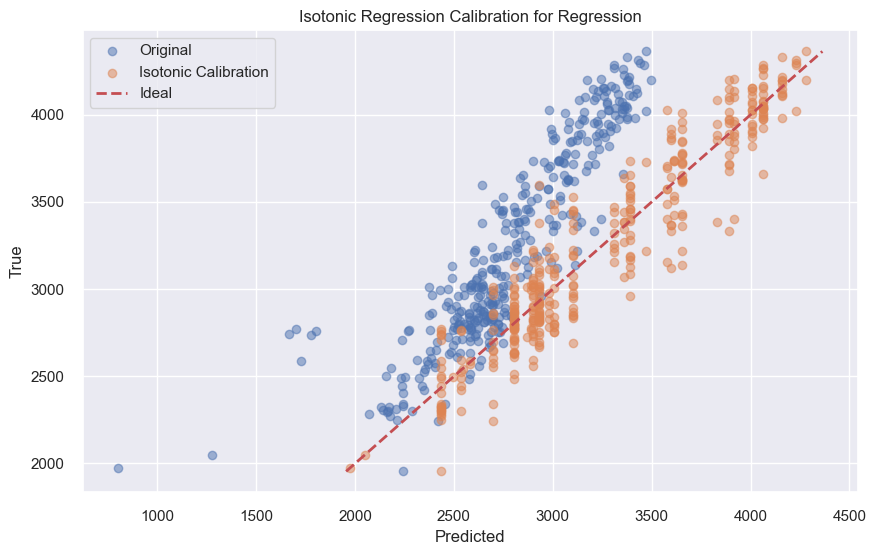

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(df_forecast['forecast_mean'], y_testreshape, alpha=0.5, label='Original')
plt.scatter(y_pred_calibrated_iso, y_testreshape, alpha=0.5, label='Isotonic Calibration')
plt.plot([y_testreshape.min(), y_testreshape.max()], [y_testreshape.min(), y_testreshape.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Isotonic Regression Calibration for Regression')
plt.legend()
plt.show()

Calculate Conformal Prediction intervals using Bootstrap method

In [25]:
final_SARIMAX = df_forecast.copy()

In [26]:
def bootstrap_prediction_interval(y_train: np.ndarray,
                                  y_fit: np.ndarray,
                                  y_pred_value: float,
                                  alpha: float = 0.05,
                                  nbootstrap: int = 1000,
                                  seed: int = None) -> tuple[float, float, float]:
    n = len(y_train)
    fe = y_train - y_fit
    percentile_lower = (alpha * 100) / 2
    percentile_higher = 100 - percentile_lower
    np.random.seed(seed)
    error_bootstrap = np.random.choice(fe, size=nbootstrap, replace=True)
    fe_lower = np.percentile(a=error_bootstrap, q=percentile_lower)
    fe_higher = np.percentile(a=error_bootstrap, q=percentile_higher)
    pi_lower = y_pred_value + fe_lower
    pi_upper = y_pred_value + fe_higher
    return pi_lower, y_pred_value, pi_upper

In [27]:
y_forecast_train = model.forecast(steps=len(dataforARIMA_train_scaled),exog=dataforARIMA_exog_train)
prediction_train2= np.ravel(y_forecast_train.values)
y_predtrain_final = scaler.inverse_transform(prediction_train2.reshape(-1,1))

In [28]:
pi_low,y_forecast_cp,pi_up = bootstrap_prediction_interval(y_train=dataforARIMA_train[' Energia (MWh) '].values.reshape(-1,).flatten(),y_fit=y_predtrain_final.flatten(),y_pred_value=y_pred_calibrated_iso.flatten(),alpha=0.05,nbootstrap=1000,seed=101)

In [29]:
final_SARIMAX['lower_PI'] = pi_low
final_SARIMAX['upper_PI'] = pi_up
final_SARIMAX['y_forecast'] = y_pred_calibrated_iso

Plotting forecast with Conformal Prediction intervals

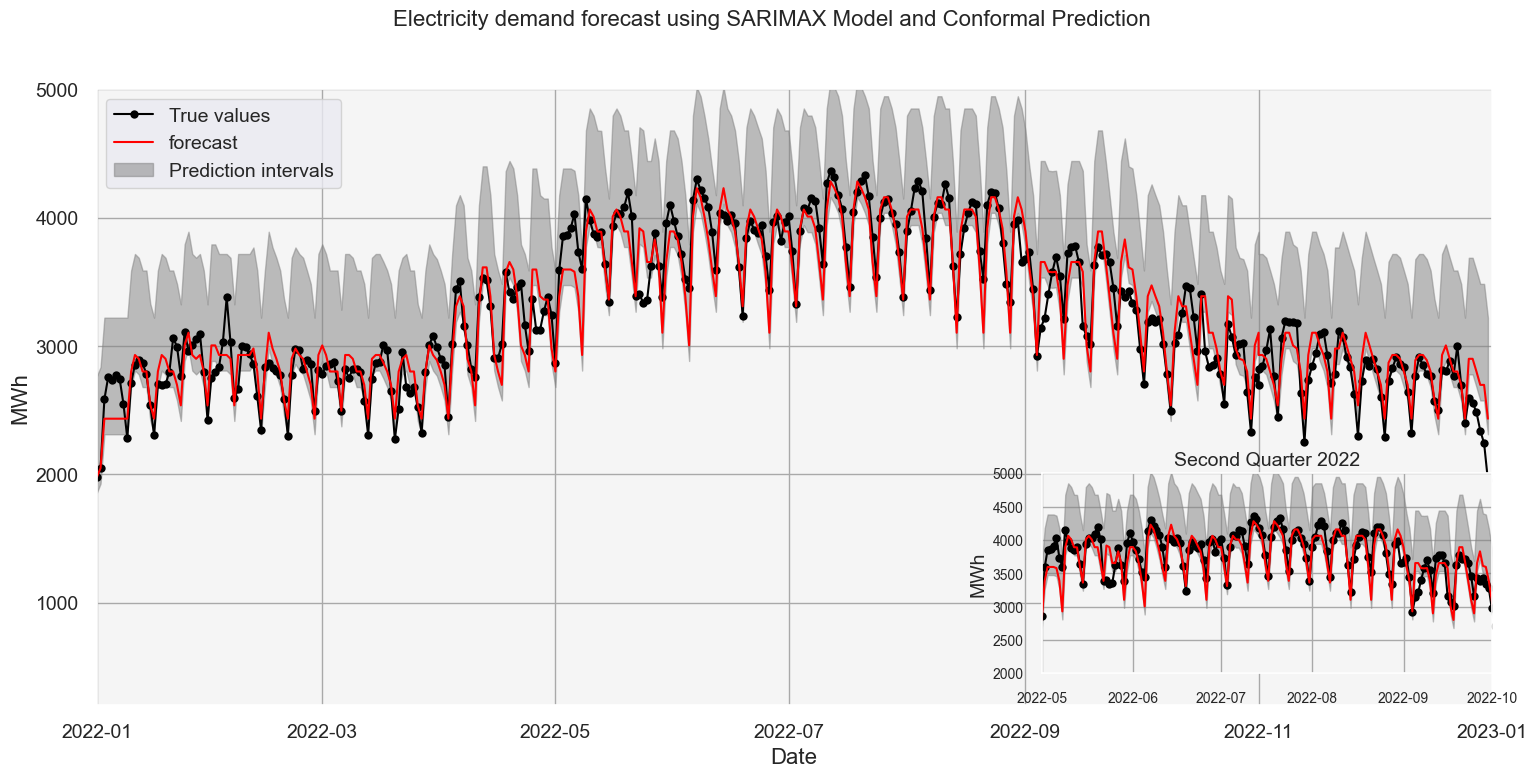

In [30]:
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'darkgray'
fig, ax1 = plt.subplots(figsize=(18,8))
fig.suptitle('Electricity demand forecast using SARIMAX Model and Conformal Prediction', fontsize=16)
ax1.set_facecolor('whitesmoke')
ax1.plot(final_SARIMAX.index, final_SARIMAX[' Energia (MWh) '], marker='o', label="True values", color='black')
ax1.plot(final_SARIMAX.index, final_SARIMAX['y_forecast'],label='forecast',color='red')
ax1.fill_between(
    final_SARIMAX.index,
    pi_up,
    pi_low,
    alpha=0.5,
    label="Prediction intervals",
    color='gray'
)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([200, 5000])
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

left, bottom, width, height = [0.65, 0.15, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height], facecolor='whitesmoke')
ax2.plot(final_SARIMAX.index, final_SARIMAX[' Energia (MWh) '],marker='o',  color='black')
ax2.plot(final_SARIMAX.index,final_SARIMAX['y_forecast'],label='forecast',color='red')
ax2.fill_between(
    final_SARIMAX.index,
    pi_up,
    pi_low,
    alpha=0.5,
    color='gray'
)
ax2.set_ylabel('MWh', fontsize=14)
ax2.set_title('Second Quarter 2022', fontsize=14)
ax2.set_ylim([2000, 5000])
ax2.set_xlim([datetime.date(2022, 5, 1), datetime.date(2022,10,1)])
ax2.tick_params(axis='both', which='major', bottom=False, top=False, labelbottom=True, labelsize=10)
ax2.grid(True)
#plt.savefig('Fig3_SARIMA_forecast_CP.svg',format='svg',dpi=1200)

Calculate Conformal Prediction metrics

In [31]:
lower_bound = pi_low
upper_bound = pi_up
y_true = final_SARIMAX[' Energia (MWh) '].values

validity,sharpness,interval_score = calculate_metricsforCP(y_true, lower_bound, upper_bound)

Arrange results in a dataframe for ease of reading

In [32]:
pd.options.display.float_format = '{:.2f}'.format
mape,mae,mse,rmse,r2 = calculate_model_accuracy_metrics(final_SARIMAX[' Energia (MWh) '].values,final_SARIMAX['y_forecast'].values)
coverage = regression_coverage_score(final_SARIMAX[' Energia (MWh) '].values,pi_low, pi_up)
modeloSARIMAX = pd.DataFrame(data=(mape,mae,mse,rmse,r2,coverage*100,validity,sharpness,interval_score), index=['MAPE (%)', 'MAE','MSE','RMSE','R2','Coverage (%)','Validity','Sharpness','Interval Score'])
modeloSARIMAX = modeloSARIMAX.rename(columns={0: 'Metrics'})
modeloSARIMAX

,Metrics
MAPE (%),4.56
MAE,143.38
MSE,34336.34
RMSE,185.30
R2,0.89
Coverage (%),77.05
Validity,0.72
Sharpness,908.36
Interval Score,909.13
